Converting PAH as Phenanthrene Equivalence (PAHphe in µg) from ship scrubber discharge data for the Salish Sea for 2019 into Salish Sea Atlantis contaminant forcing files of Phenanthrene (mg/m^3). Discharge data provided by Environment & Climate Change Canada (ECCC). 

In [1]:
import os
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from shapely.geometry import Point

In [2]:
ssam_shapefile = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
ssam = gpd.read_file(ssam_shapefile)
box_depth = ssam['BOTZ']
box_area = ssam['AREA']
box_id = ssam['BOX_ID']
box_volume = box_area * box_depth #m^3

numPolygons = 130
numLayers = 7

#box_id

### Aggregating ECCC data by Atlantis boxes

In [3]:
scrubber_data_path = '/ocean/rlovindeer/Atlantis/ShipScrubber/MEIT_2019_Data_SSAMDomain.csv'
scrubberdf1 = pd.read_csv(scrubber_data_path)
scrubberdf = scrubberdf1.sort_values(by='date_time')

In [4]:
#discharge = (scrubberdf.PAHphe * 0.001)/(scrubberdf.ww_tonnes * 1000) # This yields a constant, 0.00264
PAHphe = scrubberdf.PAHphe * 0.001 #mg
lat = scrubberdf.lat
lon = scrubberdf.long
time = scrubberdf.date_time
df_boxes = scrubberdf.BOX_ID

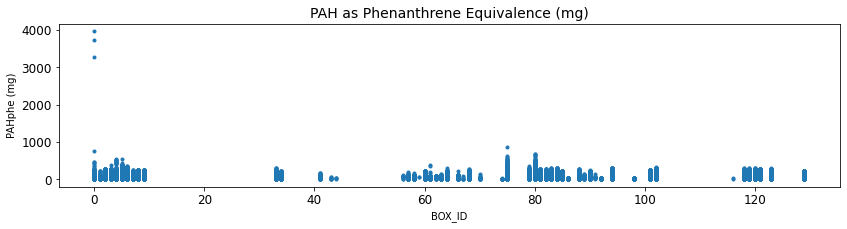

In [7]:
fig, ax = plt.subplots(figsize = (14,3))
ax.plot(df_boxes, PAHphe, '.')
ax.set_title('PAH as Phenanthrene Equivalence (mg)', fontsize = 14)
ax.set_ylabel('PAHphe (mg)')
ax.set_xlabel('BOX_ID')
ax.tick_params(labelsize=12)

In [40]:
# Min and Maax dates in data file
minDate = '2019-01-01 00:09:27'
maxDate = '2019-12-31 16:00:00'

# Atlantis time steps
outputDT = 43100.00
stepsPerDay = int(86400.0/ outputDT)

seconds2019 = np.datetime64(maxDate) - np.datetime64(minDate)
print(seconds2019)
numSteps = seconds2019/outputDT
numSteps = numSteps.astype(int)
print('numSteps = ' + str(numSteps))

31506633 seconds
numSteps = 731
2019-12-31 16:00:00


In [83]:
#len(scrubberdf.lat)
scrubberdf.lat[0]

48.4556838333

In [84]:
# aggregating data within the same box, date, and time

current_BOX_ID = None
current_date_time = None
current_PAHphe = None

dataAggregate = pd.DataFrame({'BOX_ID': [],
                            'date_time': [],
                            'PAHphe': []})

for i in range(0, len(scrubberdf.lat)):
    if scrubberdf.BOX_ID[i] == current_BOX_ID and scrubberdf.date_time[i] == current_date_time:
        current_BOX_ID = scrubberdf.BOX_ID[i]
        current_PAHphe = current_PAHphe + scrubberdf.PAHphe[i]
        current_date_time = scrubberdf.date_time[i]
    else: 
        current_PAHphe = scrubberdf.PAHphe[i]
        current_BOX_ID = scrubberdf.BOX_ID[i]
        current_date_time = scrubberdf.date_time[i]
        dataAggregate.loc[len(dataAggregate.index)] = [current_BOX_ID, current_date_time, current_PAHphe]

In [85]:
dataAggregate.shape

(101602, 3)

In [88]:
dataAggregate.to_csv("/ocean/rlovindeer/Atlantis/ShipScrubber/data_aggregated.csv")

### Creating netcdf input forcing file for Atlantis

In [75]:
# creating Atlantis PAHphe netcdf input forcing file
new_scrubber_data_path = '/ocean/rlovindeer/Atlantis/ShipScrubber/data_aggregated.csv'
new_df = pd.read_csv(new_scrubber_data_path)
new_df = new_df.sort_values(by='date_time')

PAHphe = new_df.PAHphe * 0.001 #mg
times = new_df.date_time
box = new_df.BOX_ID
numData = int(new_df.PAHphe.shape[0])
numData

101602

1. aggregate all discharge between Atlantis time steps to consolidate timesteps to 43200 seconds per timestep
1. for each discharge time step, put the discharge in the correct surface layer of each box
1. arrange the data as t, b, z, for the netcdf file
1. create netcdf file variables
1. populate netcdf file with the data and save and close netcdf file

In [98]:
# Min and Maax dates in data file
minDate = '2019-01-01 00:09:27'
maxDate = '2019-12-31 16:00:00'

# Atlantis time steps
outputDT = 43200.00
stepsPerDay = int(86400.0/ outputDT)

seconds2019 = np.datetime64(maxDate) - np.datetime64(minDate)
print(seconds2019)
numSteps = seconds2019/outputDT
numSteps = numSteps.astype(int) + 1
numSteps

31506633 seconds


730

In [99]:
# Create netcdf forcing file

netcdfFileName = "Atlantis_Scrubber_PAH_2019.nc"
try:
    os.remove(netcdfFileName)
except:
    pass
ncfile = Dataset(netcdfFileName, "w", format="NETCDF4", clobber=True)
Dataset.set_fill_on(ncfile)

# Dimensions
time = ncfile.createDimension("t", None)
b = ncfile.createDimension("b", numPolygons)
z = ncfile.createDimension("z", numLayers)

# Variables
t = ncfile.createVariable("t",np.float64, ("t",))
Phenanthrene = ncfile.createVariable("Phenanthrene",np.float64,("t", "b", "z"))

# Attributes
Phenanthrene.units = "mgPAH/m^3"
Phenanthrene.long_name = "Phenanthrene"
Phenanthrene.missing_value = 0.0000
Phenanthrene.valid_min = 0.0000
Phenanthrene.valid_max = 100000000.0

#times.units = "seconds since " + d
t.units = "seconds since 1950-01-01 00:00:00 +10"
t.dt = outputDT
t.long_name = "time"

In [100]:
# Populate time variables
seconds_from_1950 = (2019-1950)*(365*24*60*60)
timeData = np.arange(0,(numSteps)*outputDT,outputDT)
t[:] = timeData + seconds_from_1950

In [101]:
# Populate discharge data variables

DataFiller = np.zeros((numSteps, numPolygons, numLayers))

for i in range(0,numData):
    if times[i] == minDate:
        stepNum = 0
    else: 
        secs = (np.datetime64(times[i]) - np.datetime64(minDate))
        stepNum = int(np.around(secs.astype(int)/outputDT))  

    for targetIndex in range(0, numPolygons):
        if box_id[targetIndex] == box[i]:
            if box_volume[targetIndex] == 0:
                target_volume = 0
            else :
                target_volume = 1 / box_volume[targetIndex]
            
            if box_depth[targetIndex] < 26:
                layer = 0
            elif box_depth[targetIndex] == 50:
                layer = 1
            elif box_depth[targetIndex] == 100:
                layer = 2
            elif box_depth[targetIndex] == 200:
                layer = 3
            elif box_depth[targetIndex] > 200 and box_depth[targetIndex] < 401:
                layer = 4
            elif box_depth[targetIndex] > 400:
                layer = 5

            DataFiller[stepNum][int(box[i])][layer] = DataFiller[stepNum][int(box[i])][layer] + (PAHphe[i] * target_volume)
    

In [102]:
Phenanthrene[:,:,:] = DataFiller

ncfile.close()